# Setup google colab environment:

In [1]:
from google.colab import drive
drive.mount('/content/drive')
! unzip "/content/drive/Shareddrives/UwU w what's dis /shortage_BeeDataset.zip" -d ./SavedModel
! ls ./SavedModel

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: ./SavedModel/original_BeeDataset_20201121/None/92gzxNwm0Oevz5mGJtHjqKlWfaPlQinS.jpeg  
  inflating: ./SavedModel/original_BeeDataset_20201121/None/968uYuQZ3A8kzDwZq79A0BXLZZLmy01r.jpeg  
  inflating: ./SavedModel/original_BeeDataset_20201121/None/96IZRC3UmcnNZYkkDZJLJhVqgHXa5C7r.jpeg  
  inflating: ./SavedModel/original_BeeDataset_20201121/None/98et49pu44CLvTLxaezPANpOWy7KOSis.jpeg  
  inflating: ./SavedModel/original_BeeDataset_20201121/None/98Kd0zV9K06hFWqLJOvUvosEwUkUMwO9.jpeg  
  inflating: ./SavedModel/original_BeeDataset_20201121/None/99237Pvgd7ru9ACA9NpYe0CFZsmwhnov.jpeg  
  inflating: ./SavedModel/original_BeeDataset_20201121/None/99MSZgcRz9vpAJ1GVKVx6mphvw6tPid0.jpeg  
  inflating: ./SavedModel/original_BeeDataset_20201121/None/9BJaLxK7OqFgzxKgg3PNIsXC58PFe6mu.jpeg  
  inflating: ./SavedModel/original_BeeDataset_20201121/None/9cl8o1k1VVjuIOBPUZlzNJ9iPDu0hpQl.jpeg  
  inflating: ./SavedModel/original_BeeDatas

In [2]:
! mkdir /content/SavedModel/test
! mkdir /content/SavedModel/training
! cp -r /content/SavedModel/original_BeeDataset_20201121/* \
     /content/SavedModel/training
! path=''

In [3]:
# get da firsrt item in each folder in the data set and move it to the test folder
! for f in /content/SavedModel/training/*;\
   do \
    files=($f/*);\
    echo "Moving $files to testing folder";\
    mv "${files[0]}" /content/SavedModel/test/;\
   done;
! for f in /content/SavedModel/training/*;\
   do \
    files=($f/*);\
    echo "Moving $files to testing folder";\
    mv "${files[0]}" /content/SavedModel/test/;\
   done;
! for f in /content/SavedModel/training/*;\
   do \
    files=($f/*);\
    echo "Moving $files to testing folder";\
    mv "${files[0]}" /content/SavedModel/test/;\
   done;
! for f in /content/SavedModel/training/*;\
   do \
    files=($f/*);\
    echo "Moving $files to testing folder";\
    mv "${files[0]}" /content/SavedModel/test/;\
   done;
! for f in /content/SavedModel/training/*;\
   do \
    files=($f/*);\
    echo "Moving $files to testing folder";\
    mv "${files[0]}" /content/SavedModel/test/;\
   done;
! for f in /content/SavedModel/training/*;\
   do \
    files=($f/*);\
    echo "Moving $files to testing folder";\
    mv "${files[0]}" /content/SavedModel/test/;\
   done;
! for f in /content/SavedModel/training/*;\
   do \
    files=($f/*);\
    echo "Moving $files to testing folder";\
    mv "${files[0]}" /content/SavedModel/test/;\
   done;
! for f in /content/SavedModel/training/*;\
   do \
    files=($f/*);\
    echo "Moving $files to testing folder";\
    mv "${files[0]}" /content/SavedModel/test/;\
   done;
! for f in /content/SavedModel/training/*;\
   do \
    files=($f/*);\
    echo "Moving $files to testing folder";\
    mv "${files[0]}" /content/SavedModel/test/;\
   done;
! for f in /content/SavedModel/training/*;\
   do \
    files=($f/*);\
    echo "Moving $files to testing folder";\
    mv "${files[0]}" /content/SavedModel/test/;\
   done;
! for f in /content/SavedModel/training/*;\
   do \
    files=($f/*);\
    echo "Moving $files to testing folder";\
    mv "${files[0]}" /content/SavedModel/test/;\
   done;
! for f in /content/SavedModel/training/*;\
   do \
    files=($f/*);\
    echo "Moving $files to testing folder";\
    mv "${files[0]}" /content/SavedModel/test/;\
   done;


Moving /content/SavedModel/training/None/00REy4TadyIXjZFaiMRgFCWvVlXlAKf9.jpeg to testing folder
Moving /content/SavedModel/training/Varroa/01EnJx1wbrJpVlMX5lbJ7h4lB2ayKfwJ.jpeg to testing folder
Moving /content/SavedModel/training/Wasps/0g5WQDsDFOHoR6CGGADApx0wiwsCNdpH.jpeg to testing folder
Moving /content/SavedModel/training/None/04i74r4jUSARfi2Thf48qQFfMBT20Ykc.jpeg to testing folder
Moving /content/SavedModel/training/Varroa/03ag5gsILeRUJPGW2zGnDE4uJ5s7VJFA.jpeg to testing folder
Moving /content/SavedModel/training/Wasps/0GYnOAB6XpgFUyHATnzOC709OvB1kYGy.jpeg to testing folder
Moving /content/SavedModel/training/None/07l6B3OiqJfHlfkIYovbRSvrrg3tI0bg.jpeg to testing folder
Moving /content/SavedModel/training/Varroa/09R3TLIfdagOjd1ULGkHYeqMDmDgVNaI.jpeg to testing folder
Moving /content/SavedModel/training/Wasps/0iboTdzreOwH7DXs1X9ZSj5tu86chgv3.jpeg to testing folder
Moving /content/SavedModel/training/None/096w3dBizGlF5Fyc0CDWngiqObnzAhLN.jpeg to testing folder
Moving /content/Saved

In [4]:
# dataset_path = "/content/SavedModel/original BeeDataset_20201121"
dataset_path = "/content/SavedModel/training"
model_export_path = "/content/drive/Shareddrives/UwU w what's dis "
# labels_file = #example: C:\Users\Chuon\OneDrive\Tài liệu\GitHub\aiot-beehive\test\data.json
# export_path =

# Import libraries

In [5]:
import os
import cv2
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# from dotenv import load_dotenv
# load_dotenv()

# Load data:


In [6]:

root_dir = os.getcwd()
# data_dir = os.path.join(os.getenv('dataset_path'))
data_dir = dataset_path
# test_dir = os.path.join(root_dir, 'test-dataset')
test_dir = "/content/SavedModel/test"

In [7]:
IMG_SIZE = (150, 300)
IMG_SHAPE = IMG_SIZE + (3,)

In [8]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=42,
    validation_split=0.2,  # 20% of the data for validation
    subset='both',
    batch_size=32,
    image_size=IMG_SIZE,
)

Found 5438 files belonging to 3 classes.
Using 4351 files for training.
Using 1087 files for validation.


In [9]:
class_names = train_ds.class_names
class_num = len(class_names)

# Augmentation (can be disable duo to dataset is large enought):

In [10]:
# tf.random.set_seed(42)
# random.seed(42)
# np.random.seed(42)

In [11]:
# data_augment = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal_and_vertical'),
#                                     tf.keras.layers.RandomRotation(0.2),
#                                     ])

# Image normalization

In [12]:

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Start training

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               )

9406464/9406464 [==============================] - 1s 0us/step


In [15]:
base_model.trainable = False

In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 300, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 150, 32)          864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 150, 32)          128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 150, 32)          0         ['bn_Conv1[

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(class_num, activation='softmax')

In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augment(inputs)
x = inputs
# x = preprocess_input(x)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 300, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 150, 300, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 150, 300, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 5, 10, 1280)       2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [20]:
base_learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              )

In [21]:
initial_epochs = 14

In [22]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    )

Epoch 1/14
136/136 [==============================] - 21s 72ms/step - loss: 0.9908 - accuracy: 0.5495 - val_loss: 0.7368 - val_accuracy: 0.6964
Epoch 2/14
136/136 [==============================] - 8s 54ms/step - loss: 0.7169 - accuracy: 0.6881 - val_loss: 0.6022 - val_accuracy: 0.7470
Epoch 3/14
136/136 [==============================] - 8s 56ms/step - loss: 0.6329 - accuracy: 0.7221 - val_loss: 0.5355 - val_accuracy: 0.7682
Epoch 4/14
136/136 [==============================] - 9s 65ms/step - loss: 0.5766 - accuracy: 0.7456 - val_loss: 0.5046 - val_accuracy: 0.7682
Epoch 5/14
136/136 [==============================] - 8s 55ms/step - loss: 0.5352 - accuracy: 0.7594 - val_loss: 0.4756 - val_accuracy: 0.7829
Epoch 6/14
136/136 [==============================] - 8s 54ms/step - loss: 0.5154 - accuracy: 0.7644 - val_loss: 0.4551 - val_accuracy: 0.7912
Epoch 7/14
136/136 [==============================] - 8s 58ms/step - loss: 0.4890 - accuracy: 0.7810 - val_loss: 0.4379 - val_accuracy: 0.795

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Illustrator:

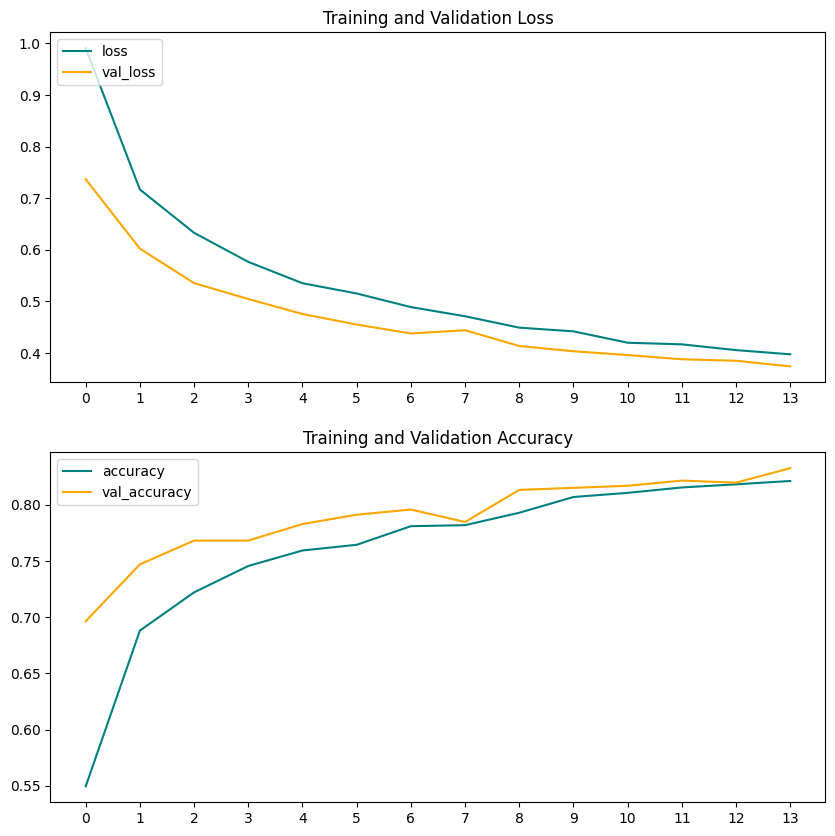

In [24]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(loss, color='teal', label='loss')
plt.plot(val_loss, color='orange', label='val_loss')
plt.xticks(range(history.epoch[-1] + 1))
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(acc, color='teal', label='accuracy')
plt.plot(val_acc, color='orange', label='val_accuracy')
plt.xticks(range(history.epoch[-1] + 1))
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.show()

In [25]:
base_model.trainable = True
fine_tune_layers = 120

In [26]:
for layer in base_model.layers[:fine_tune_layers]:
    layer.trainable = False

In [27]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(
                  learning_rate=base_learning_rate/10),
              metrics=['accuracy'],
              )

# Tune:

In [28]:
fine_tune_epochs = 14
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1]+1,
                         validation_data=val_ds,
                         )

Epoch 15/28
136/136 [==============================] - 20s 79ms/step - loss: 0.3451 - accuracy: 0.8497 - val_loss: 0.2863 - val_accuracy: 0.8859
Epoch 16/28
136/136 [==============================] - 10s 75ms/step - loss: 0.2497 - accuracy: 0.9069 - val_loss: 0.2444 - val_accuracy: 0.8960
Epoch 17/28
136/136 [==============================] - 10s 73ms/step - loss: 0.1983 - accuracy: 0.9265 - val_loss: 0.1918 - val_accuracy: 0.9310
Epoch 18/28
136/136 [==============================] - 9s 68ms/step - loss: 0.1605 - accuracy: 0.9414 - val_loss: 0.1690 - val_accuracy: 0.9439
Epoch 19/28
136/136 [==============================] - 10s 74ms/step - loss: 0.1307 - accuracy: 0.9563 - val_loss: 0.1585 - val_accuracy: 0.9439
Epoch 20/28
136/136 [==============================] - 10s 74ms/step - loss: 0.1057 - accuracy: 0.9614 - val_loss: 0.1749 - val_accuracy: 0.9328
Epoch 21/28
136/136 [==============================] - 11s 76ms/step - loss: 0.0950 - accuracy: 0.9690 - val_loss: 0.1380 - val_acc

In [29]:
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

# Illustrator:

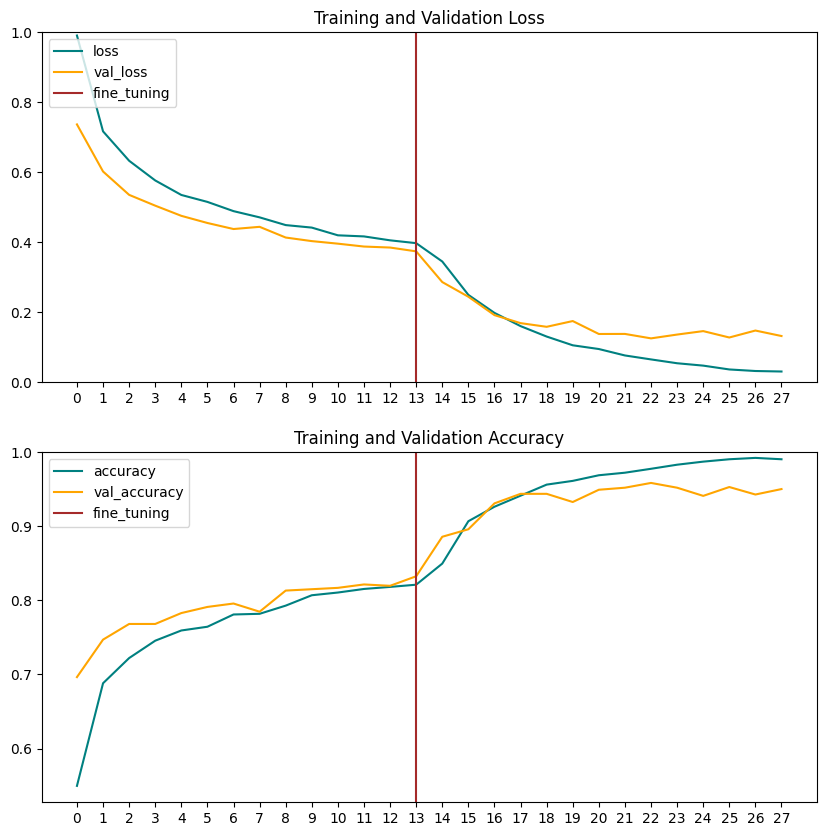

In [30]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(loss, color='teal', label='loss')
plt.plot(val_loss, color='orange', label='val_loss')
plt.xticks(range(history_fine.epoch[-1]+1))
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), color='brown', label='fine_tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(acc, color='teal', label='accuracy')
plt.plot(val_acc, color='orange', label='val_accuracy')
plt.xticks(range(history_fine.epoch[-1]+1))
plt.ylim([min(plt.ylim()), 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), color='brown', label='fine_tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.show()

1/1 [==============================] - 0s 22ms/step


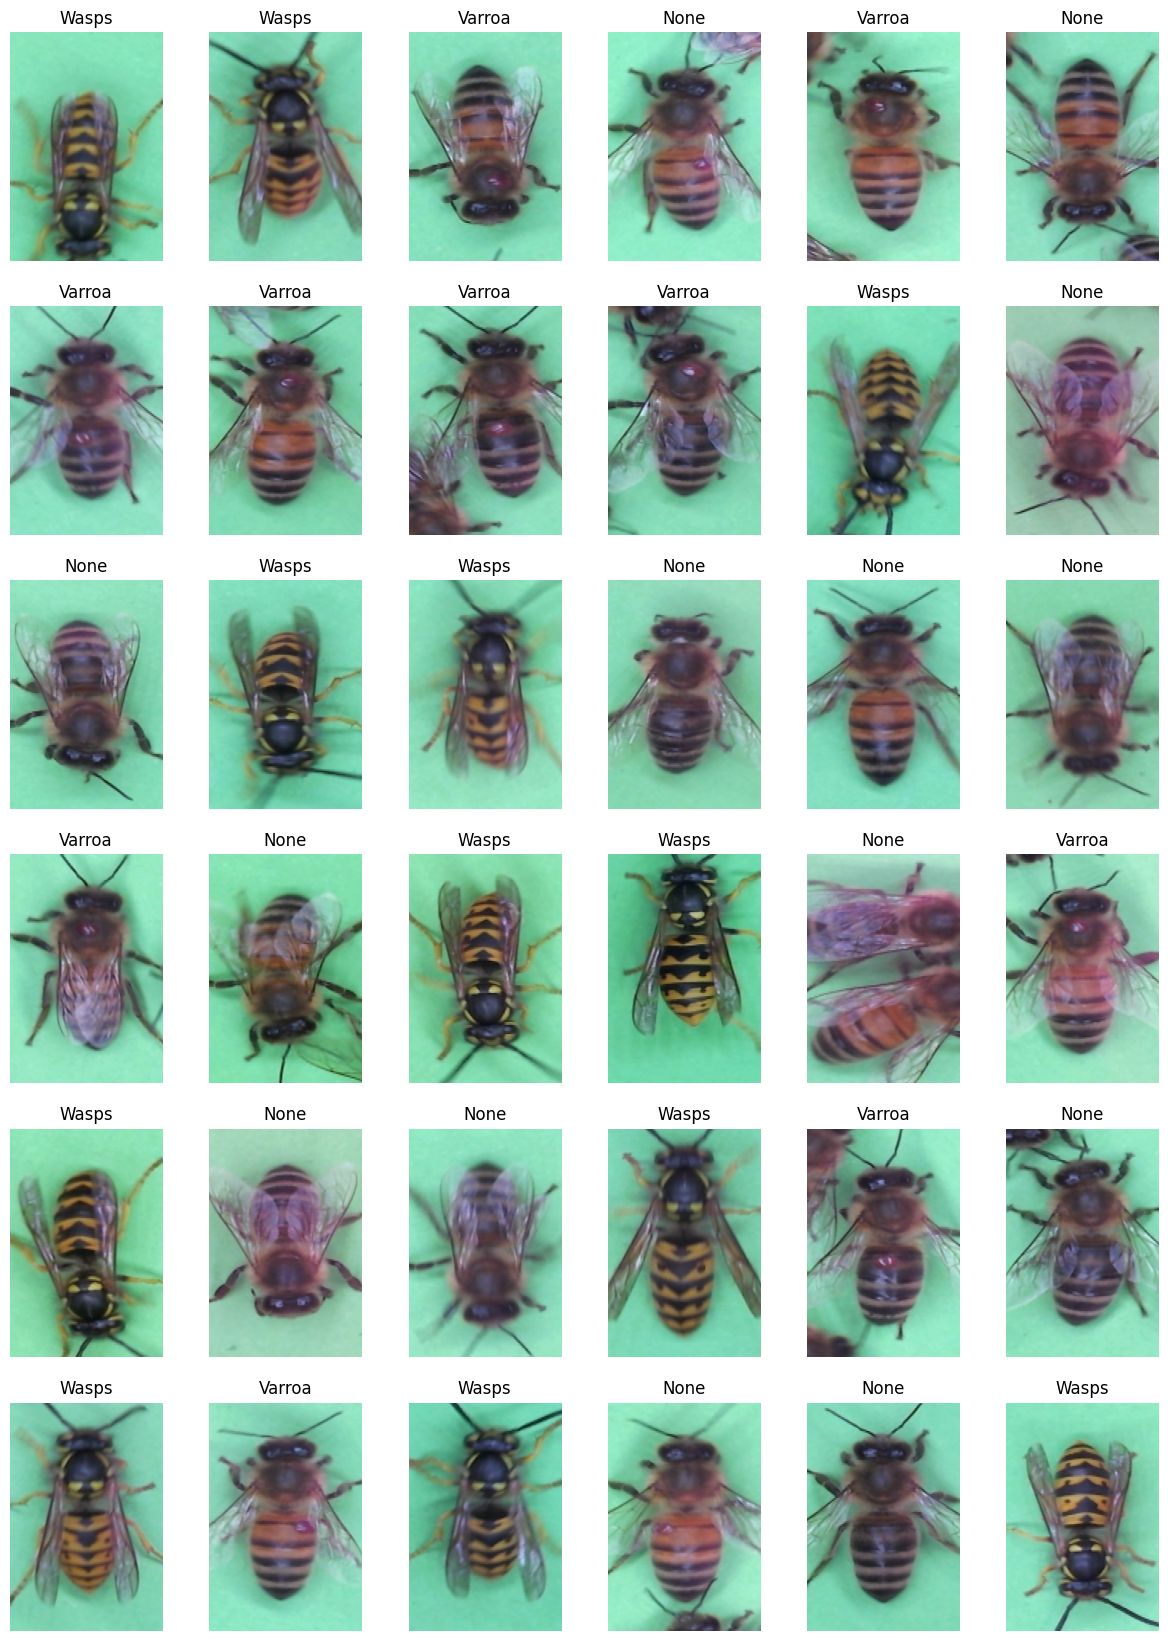

In [31]:
plt.figure(figsize=(15, 35))

for index, image in enumerate(os.listdir(test_dir)):
    img = cv2.imread(os.path.join(test_dir, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, IMG_SIZE)

    yhat = model.predict(np.expand_dims(img, 0))
    yhat = tf.nn.softmax(yhat[0])
    yhat = np.array(yhat)

    plt.subplot(10, 6, index + 1)
    plt.imshow(img.numpy().astype('uint8'))
    plt.title(class_names[np.argmax(yhat)])
    plt.axis('off')

    # Set the size of the displayed image
    plt.gcf().get_axes()[index].set_aspect(3)  # Adjust the value (3) as needed

plt.show()

# Save model

In [32]:
# path
# model.save(os.path.join(root_dir, 'models',
#            'seeded_model.keras'))
# Save model on the shared drive, separated by time

from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%Y-%m-%d-%H-%M")

model.save(os.path.join(model_export_path, 'models',
           'seeded_model.keras',dt_string))